# Как рассказать историю с помощью данных

Нужно подготовить материал для презентации инвесторам проекта по открытию ресторана.

## Структура проекта
1. [Начало работы](#start)
1. [Предобработка](#preprocessing)
1. [Анализ](#analisys)
1. [Выводы](#conclusions)

---

## Начало работы
<a id='start' name='start'></a>
Сделаем всё, чтобы начать работать

In [4]:
!pip install --upgrade seaborn -q

In [5]:
import pandas as pd
import numpy as np
from os import environ
import re
import seaborn as sns
import matplotlib.pyplot as plt
import warnings

warnings.filterwarnings('ignore')

In [6]:
pd.set_option(
    'display.float_format', lambda x: '%.3f' % x
)

In [7]:
sns.set(
    rc = {
        'figure.figsize': (15, 7),
        'figure.dpi': 80,
        'axes.grid': True,
        'axes.grid.axis': 'x',
        'axes.grid.which': 'both',
        'grid.alpha': .4,
        'xtick.minor.visible': True,
        },
    palette = 'colorblind',
    style = 'ticks'
)

In [8]:
def read_csv(func: 'pd.read_csv'=pd.read_csv) ->pd.DataFrame:
    """Wrapper for pd.read_csv."""
    def wrapper(*args, **kwargs: 'pd.read_csv parameters') -> pd.DataFrame:
        """
        Return a DataFrame from csv with true and ordered columns and sort by
        datetime, and display 5 randow rows and df.info().
        """
        df = func(*args, **kwargs)
        
        columns_indeces = kwargs.get(
            'usecols', 
            np.arange(df.shape[1])
        )
        df = df.iloc[:, columns_indeces]

        df.columns = [
            re.sub('([a-z])([A-Z]+)', r'\1_\2', col).strip().lower().replace(' ', '_') 
            for col 
            in df.columns
            ]

        if not df.select_dtypes('datetime').isnull:
            date_column = df.select_dtypes('datetime').columns[0]
            df = df.sort_values(date_column).reset_index(drop=True)

        display(
            df.sample(5, random_state=42).sort_index()
        )
        print('---------------------------------')
        df.info(memory_usage='deep')

        return df
    return wrapper

true_read_csv = read_csv()

In [9]:
try:
    PATH = environ['REST_DATA']
except KeyError:
    PATH = '/datasets/rest_data.csv'

df = true_read_csv(
    filepath_or_buffer = PATH,
    false_values = ['нет'],
    true_values = ['да'],
    names = ['id', 'name', 'chain', 'type', 'address', 'sits'],
    skiprows = [0],
    usecols = [0, 1, 3, 5, 4, 2],
)

,id,name,type,sits,address,chain
2478,27730,Столовая «ГАЛА ПИЦЦА»,столовая,46,"город Москва, Варшавское шоссе, дом 116",False
6081,156891,Чудо Пекарня Шаргунь,закусочная,0,"город Москва, Севастопольский проспект, дом 15...",False
8819,156321,Кафе «Тетя Мотя»,кафе,100,"город Москва, проезд Сокольнического Круга, дом 7",False
12062,182973,БУРГЕР КИНГ,кафе,60,"город Москва, Ярославское шоссе, дом 69",True
14197,206042,Чебуречная,магазин (отдел кулинарии),0,"город Москва, Открытое шоссе, дом 9, строение 9",False


---------------------------------
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 15366 entries, 0 to 15365
Data columns (total 6 columns):
id         15366 non-null int64
name       15366 non-null object
type       15366 non-null object
sits       15366 non-null int64
address    15366 non-null object
chain      15366 non-null bool
dtypes: bool(1), int64(2), object(3)
memory usage: 5.9 MB


Типы данных ожидаемые, пропусков нет.
<br>
Перейдём к предобработке.

---

## Предобработка
<a name='preprocessing' id='preprocessing'></a>
Найдём мусор, уберём мусор, сделаем разную предобработку

Прежде чем искать мусор в данных, избавимся от мусора в названии заведения. Нужно убрать все кавычки и большие буквы.
<br>
Начнём с названия:

In [10]:
df['name'] = df['name'].apply(lambda x: re.sub("«|»", "", x.lower().strip()))

К адресу применим `.lower()` и посмотрим на дубликаты:

In [11]:
df['address'] = df['address'].str.lower()

In [12]:
df[['name', 'address']].duplicated().sum()

227

In [13]:
df['id'].duplicated().sum()

0

Интересно - имется 227 заведений, у которых совпадают название и адрес (крайне маловероятно, что в одном здании находится два одинаковых заведения), но поле *id* не имеет дубликатов. 
<br>
Удалим поле *id* и дубликаты:

In [14]:
df = df.drop_duplicates(subset=['name', 'address']).reset_index(drop=True).drop(columns='id')

Теперь взглянем на типы заведений в таблице:

In [15]:
df['type'].value_counts()

кафе                                 5991
столовая                             2572
ресторан                             2269
предприятие быстрого обслуживания    1885
бар                                   849
буфет                                 565
кафетерий                             392
закусочная                            344
магазин (отдел кулинарии)             272
Name: type, dtype: int64

Заменим *предприятие быстрого обслуживания* на более короткий *фастфуд*:

In [16]:
df['type'] = df['type'].replace({
    'предприятие быстрого обслуживания': 'фастфуд',
     'магазин (отдел кулинарии)': 'магазин'
     })

Посмотрим на распределение количества посадочных мест:

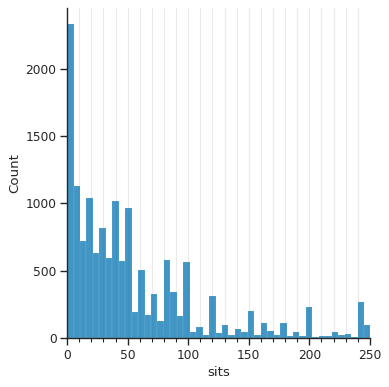

In [17]:
sns.displot(
    data = df['sits'],
)
plt.xlim(0, 250)
plt.show()

Много заведений имеют 0 посадочных мест. Взглянем на них:

In [18]:
df[df['sits'] == 0]['type'].value_counts()

фастфуд       689
кафе          299
закусочная    181
магазин       144
кафетерий     110
буфет          63
ресторан       44
бар            27
столовая       19
Name: type, dtype: int64

Удалять их не будем, заменим самые очевидные ошибки на *np.nan*:

In [19]:
for t in ('ресторан', 'бар', 'столовая', 'кафе'):
    df.loc[df['type'] == t, 'sits'] = df.loc[df['type'] == t, 'sits'].replace(0, np.nan)

Добавим для каждого адреса улицу и район:

In [20]:
URL = 'https://docs.google.com/spreadsheets/d/e/2PACX-1vQLUBfGf5isQQoE0uvn6jUJrmV0vV1EXNZedQdvbJ8Cx-j9j78FTzjlPmLyHJeS-feqyGJK_EHdF90j/pub?gid=928527323&single=true&output=csv'

df = df.merge(pd.read_csv(URL), how='left', on='address')

[Парсинг адресов](https://embed.deepnote.com/73c6fdc9-2380-4d92-b495-95da9dd36eb1/2f7ddd39-50a6-4a8c-a715-3da40433e49c/00000-81c84b08-2b42-4be0-9c99-883aa89eb481?height=775)

---

## Анализ данных
<a name='analisys' id='analisys'></a>
Посмотрим на разные штуки, сделаем разные выводы

Сперва посмотрим на распределение видов общественного питания:

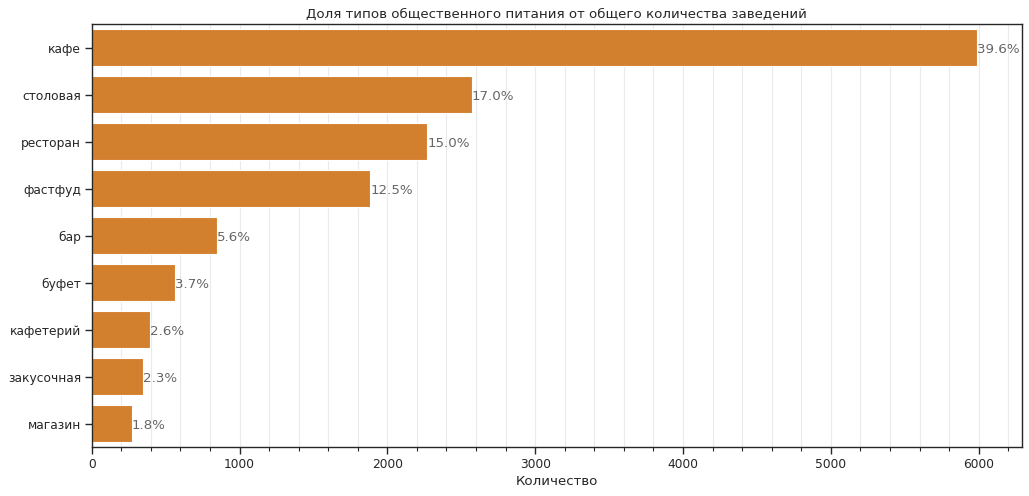

In [21]:
data = df['type'].value_counts()

ax = sns.barplot(
    data = data.reset_index(),
    x = 'type',
    y = 'index',
    color = '#ee8012'
)

for rect in ax.patches:
    ax.text(
        x = rect.get_width(),
        y = rect.get_y() + rect.get_height() / 1.6,
        s = '{:.1%}'.format(rect.get_width() / len(df['type'])),
        color = '#666666'
    )

plt.title('Доля типов общественного питания от общего количества заведений')
plt.ylabel('')
plt.xlabel('Количество')

plt.show()

Больше всего разных кафе, а меньше всего - отделений с едой в магазинах.
<br>
Посморим на долю сетевых заведений:

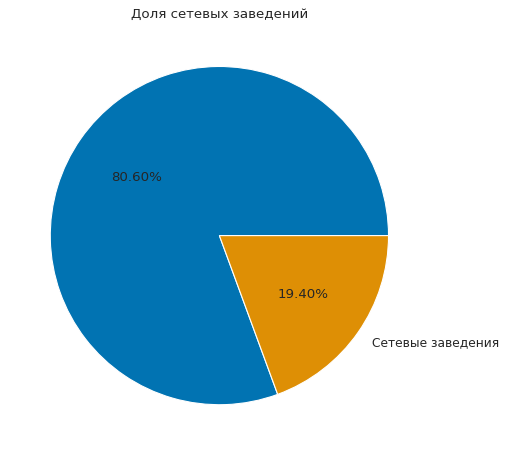

In [22]:
df['chain'].map({True: 'Сетевые заведения', False: ''}).value_counts(normalize=True).plot.pie(autopct='%.2f%%')

plt.title('Доля сетевых заведений')
plt.ylabel('')
plt.show()

Сетевых заведений всего 20% от общего количества.
<br>
Посмотрим на долю сетевых заведений по типу заведений:

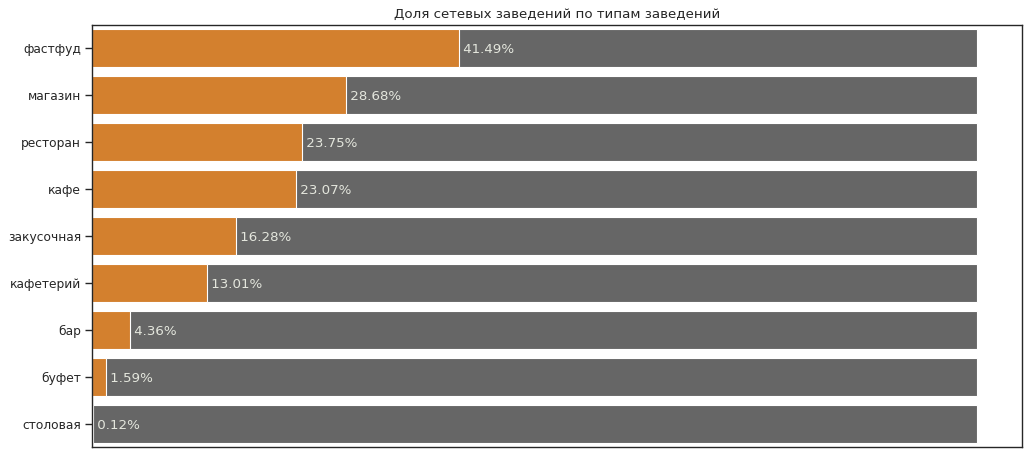

In [23]:
data = (
    (df.loc[df['chain'], 'type'].value_counts() / df['type'].value_counts())
    .sort_values(ascending=False)
    .reset_index()
    )
data.columns = ['type', 'chain']
data['no_chain'] = 1

ax = sns.barplot(
    data = data,
    x = 'no_chain',
    y = 'type',
    color = '#666666',
    )

sns.barplot(
    data = data,
    x = 'chain',
    y = 'type',
    color = '#ee8012',
    ax = ax
)

for rect in ax.patches[9:]:
    ax.text(
        rect.get_width(), 
        rect.get_y() + rect.get_height() / 1.6,
        ' {:.2%}'.format(rect.get_width()),
        color='#e4e6dd'
        )

plt.xticks(ticks=[])
plt.ylabel('')
plt.xlabel('')
plt.title('Доля сетевых заведений по типам заведений')

plt.minorticks_off()

plt.show()

Больше всего сетевых заведений ожидаемо в категории *фастфуд*.
<br>
Посмотрим на топ сетей:

In [24]:
df[df['chain']]['name'].value_counts().head(10)

шоколадница        154
kfc                152
макдоналдс         147
бургер кинг        136
теремок             93
домино'с пицца      90
крошка картошка     89
суши wok            72
милти               72
папа джонс          51
Name: name, dtype: int64

Посмотрим на распределение количества посадочных мест для сетевых заведений:

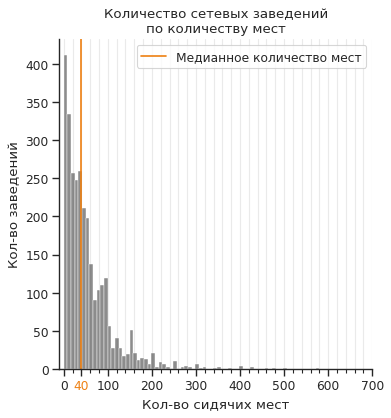

In [25]:
data = df.loc[df['chain'], 'sits']

ax = sns.displot(
    data = data,
    color = '#666666',
)

plt.axvline(data.median(), color='#ee8012', label='Медианное количество мест')

plt.xticks(ticks=np.append(plt.xticks()[0], data.median()))
plt.gca().get_xticklabels()[-1].set(color = '#ee8012')

plt.title('Количество сетевых заведений\nпо количеству мест')
plt.ylabel('Кол-во заведений')
plt.xlabel('Кол-во сидячих мест')

plt.xlim(-10)
plt.legend()

plt.show()

Медианное количество мест для сетевых заведений - 40, что позволяет сделать вывод о распространённости сетевых заведений с небольшим количеством посадочных мест.
<br>
Посмотрим на количество посадочных мест в "среднем" заведении каждого типа (посчитаем медиану, чтобы не учитывать выбросы):

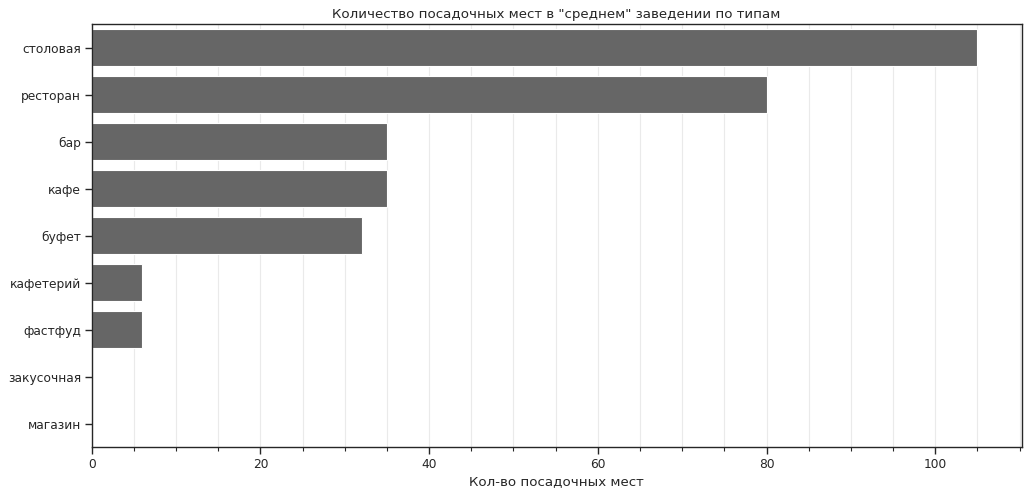

In [26]:
data = df.groupby('type')['sits'].describe(percentiles=[0.5]).sort_values('50%', ascending=False).reset_index()
sns.barplot(
    data = data,
    y = 'type',
    x = '50%',
    color = '#666666'
)

plt.title('Количество посадочных мест в "среднем" заведении по типам')
plt.ylabel('')
plt.xlabel('Кол-во посадочных мест')

plt.show()

Ожидаемо больше всего посадок в столовых, а в магазинах и закусочных посадок нет совсем. Фастфуд же расположился на последнем месте с 5 местами.
<br>
Определим самые "густонаселённые" общепитом улицы:

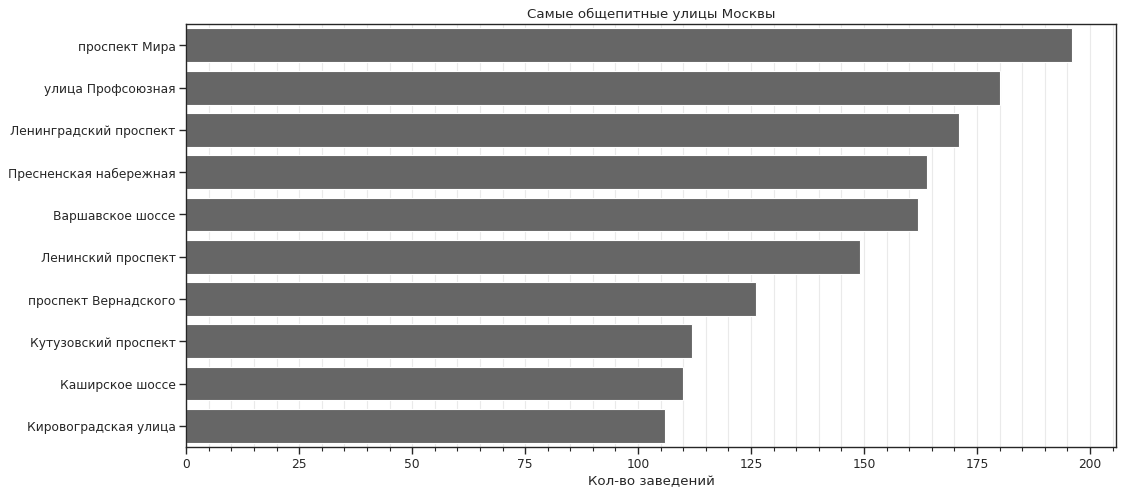

In [39]:
streets_cnt = df['street'].value_counts()

sns.barplot(
    data = streets_cnt.reset_index().head(10),
    y = 'index',
    x = 'street',
    color = '#666666'
)

plt.title('Самые общепитные улицы Москвы')
plt.ylabel('')
plt.xlabel('Кол-во заведений')

plt.show()

И сразу же определим районы, которые пересакают эти улицы:

In [28]:
top_locations = df.loc[df['street'].isin(streets_cnt.head(10).index), 'location'].value_counts()
top_locations

Пресненский                  164
Чертаново Центральное         89
Тропарево-никулино            85
Мещанский                     64
Обручевский                   63
Дорогомилово                  61
Беговой                       59
Нагатино-садовники            57
Свиблово                      56
Аэропорт                      56
Фили-давыдково                51
Донской                       48
Алексеевский                  48
Чертаново Южное               47
Москворечье-сабурово          45
Чертаново Северное            44
Нагорный                      43
Теплый Стан                   43
Гагаринский                   41
Раменки                       40
Коньково                      35
Черемушки                     35
Хорошевский                   32
Академический                 25
Якиманка                      25
Сокол                         24
Останкинский                  20
Ломоносовский                 18
проспект Вернадского          17
Ясенево                       14
Орехово-бо

Посмотрми на районы, которые пересекают улицы с всего одним заведением:

In [29]:
bottom_locations = df.loc[df['street'].isin(streets_cnt[streets_cnt == 1].index), 'location'].value_counts()
bottom_locations

Хамовники              27
Таганский              26
Басманный              23
Тверской               20
Пресненский            20
                       ..
Западное Дегунино       1
Капотня                 1
Лианозово               1
Бескудниковский         1
Очаково-матвеевское     1
Name: location, Length: 117, dtype: int64

Взглянем на распределение количества посадок для "топовых" районов:

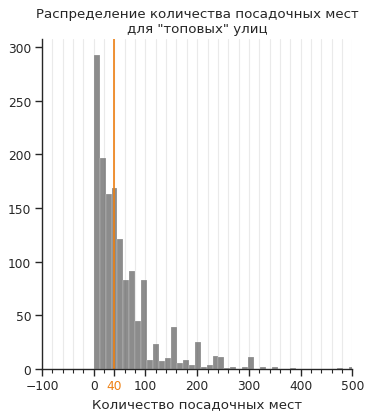

In [30]:
data = df.loc[df['street'].isin(streets_cnt.head(10).index), 'sits']
sns.displot(
    data = data,
    color = '#666666'
)

plt.xlim(-20, 500)

plt.axvline(data.median(), color='#ee8012')

plt.xticks(ticks=np.append(plt.xticks()[0], data.median()))
plt.gca().get_xticklabels()[-1].set(color = '#ee8012')

plt.title('Распределение количества посадочных мест\nдля "топовых" улиц')
plt.ylabel('')
plt.xlabel('Количество посадочных мест')

plt.show()

Распределение точно такое же, как и на сетевых заведениях - на популярных улицах преобладают небольшие заведения с менее чем 40 посадками.
<br>
Код сбора датасета для визуализаций:

In [31]:
# import geopandas

# geo_df = geopandas.read_file('/work/mo.geojson')

# df['in_top_10_street'] = df['street'].isin(streets_cnt.head(10).index)
# df['locs_with_top_streets'] = df['location'].isin(top_locations.index)
# df['locs_with_bottom_streets'] = df['location'].isin(bottom_locations.index)

# df.loc[~df['location'].isna(), 'location'] = df.loc[~df['location'].isna(), 'location'].apply(
#     lambda x: x.lower().replace('ё', 'е').split(',')[0].strip()
#     )
# geo_df['NAME'] = geo_df['NAME'].str.lower().str.replace('ё', 'е').str.replace('"', '')

# df = df.join(pd.read_csv('/work/places.csv')[['latitude', 'longitude']])
# df = geo_df[['NAME', 'geometry']].merge(df, left_on='NAME', right_on='location', how='right')
# df.iloc[:, 1:].to_csv('df.csv', index=False)

---

## Выводы
<a name='conclusions' id='conclusions'></a>
Подведём итоги

Проведя анализ имеющихся данных о расположении заведений, можно сделать такие выводы:
- нужно открывать **кафе** или **фастфуд**, потому что эти форматы распологают к наличию роботов-официантов (рестораны требуют высококлассного обслуживания, например)
- количетсво посадочных мест должно быть небольшим (так же ограничивается роботами-официантами)
- район - юго-запад города, потому что там сконцентрированы основное количество заведений 

[Ссылка на презентацию](https://drive.google.com/file/d/1gWlXHTc2fhVPKpfP9KGjEPE4oZtJ4Gf1/view?usp=sharing)

<a style='text-decoration:none;line-height:16px;display:flex;color:#5B5B62;padding:10px;justify-content:end;' href='https://deepnote.com?utm_source=created-in-deepnote-cell&projectId=73c6fdc9-2380-4d92-b495-95da9dd36eb1' target="_blank">
 </img>
Created in <span style='font-weight:600;margin-left:4px;'>Deepnote</span></a>